# Welcome to Web Traffic Timeseries Model

by: I Gusti Bagus A

### Import all dependencies

In [ ]:
pip install pydot==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install graphviz==0.10.1

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
from keras import callbacks
from keras.layers import Dense, LSTM
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import Dataset

In [ ]:
df = pd.read_csv('validation_score.csv')

In [ ]:
df.head()

Unnamed: 0   median7  median14  median21  median28  median35  median42  \
0           0  0.394786  0.398010  0.405826  0.405826  0.405826  0.405826   
1           1  0.415525  0.436615  0.484943  0.542946  0.484943  0.513212   
2           2  0.688429  0.500956  0.500956  0.492091  0.492091  0.492091   
3           3  0.356799  0.347737  0.356799  0.347737  0.356799  0.356799   
4           4  0.443860  0.453087  0.442593  0.489076  0.586340  0.586340   

   median49  median7_h  median14_h  median21_h  median28_h  median35_h  \
0  0.405826   0.489267    0.415286    0.405018    0.403895    0.405018   
1  0.503193   0.442488    0.432065    0.488515    0.539954    0.505501   
2  0.492091   0.531118    0.532642    0.500956    0.492091    0.497236   
3  0.356799   0.592931    0.340882    0.340882    0.340882    0.356799   
4  0.586340   0.475404    0.507502    0.485196    0.485196    0.573371   

   median42_h  median49_h   holiday  holiday_log  yearly_log  
0    0.405018    0.403465  0.519470     0.424500    0.636273  
1    0.507897    0.492611  0.748011     0.650149    0.409339  
2    0.497236    0.497236  0.592786     0.527832    0.530204  
3    0.356799    0.356799  0.486648     0.398567    0.346489  
4    0.586340    0.586340  0.518994     0.496272    0.828707

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   145063 non-null  int64  
 1   median7      145063 non-null  float64
 2   median14     145063 non-null  float64
 3   median21     145063 non-null  float64
 4   median28     145063 non-null  float64
 5   median35     145063 non-null  float64
 6   median42     145063 non-null  float64
 7   median49     145063 non-null  float64
 8   median7_h    145063 non-null  float64
 9   median14_h   145063 non-null  float64
 10  median21_h   145063 non-null  float64
 11  median28_h   145063 non-null  float64
 12  median35_h   145063 non-null  float64
 13  median42_h   145063 non-null  float64
 14  median49_h   145063 non-null  float64
 15  holiday      145063 non-null  float64
 16  holiday_log  145063 non-null  float64
 17  yearly_log   145063 non-null  float64
dtypes: float64(17), int64(1)

### Preprocessing

In [ ]:
df = df[:12000]

#### Rename Unnamed column

In [ ]:
df = df.rename(columns={'Unnamed: 0': 'series'})

##### Check Null Value in dataset

In [ ]:
df.isnull().sum()

series         0
median7        0
median14       0
median21       0
median28       0
median35       0
median42       0
median49       0
median7_h      0
median14_h     0
median21_h     0
median28_h     0
median35_h     0
median42_h     0
median49_h     0
holiday        0
holiday_log    0
yearly_log     0
dtype: int64

##### Data Visualization

In [ ]:
dates = df['series'].values
median7_h  = df['median7_h'].values

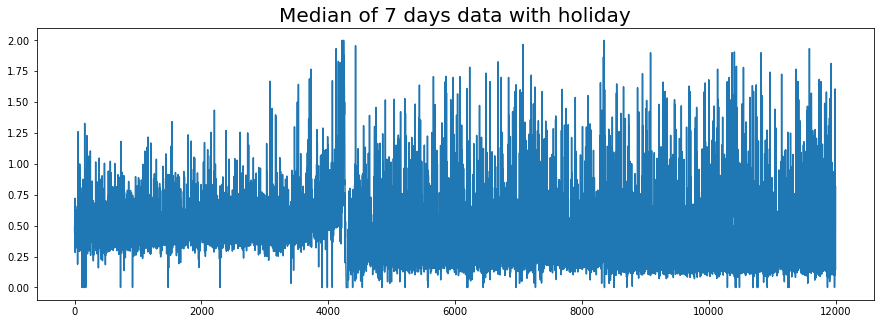

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, median7_h)
plt.title('Median of 7 days data with holiday',
          fontsize=20);

### Check Max Data Max Value and Minimum Value

In [ ]:
maximum = df['median7_h'].max()
print(maximum)

2.0


In [ ]:
minimum = df['median7_h'].min()
print(minimum)

0.0


#### Calculate Callback value

In [ ]:
callback_value = 0.1 * (maximum - minimum)

### Data Splititng

In [ ]:
train_median7h, test_median7h, train_dates, test_dates = train_test_split(median7_h, dates, test_size=0.2)

#### windowed dataset function

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

#### Convert the timeseries attributes into numpy

In [ ]:
train_set = windowed_dataset(train_median7h, window_size=30, batch_size=50, shuffle_buffer=500)
test_set = windowed_dataset(test_median7h, window_size=30, batch_size=50, shuffle_buffer=500)

### Create Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(5, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.8)

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

### Create Callbacks

In [ ]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< callback_value):
      print("\nYour Mean Absolute Error < 10% from data scale!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

### Fit Model

In [ ]:
history = model.fit(train_set, epochs=50, callbacks=[callbacks], validation_data=(test_set), verbose=2)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

192/192 - 10s - loss: 0.1087 - mae: 0.3840 - val_loss: 0.0900 - val_mae: 0.3367
Epoch 2/50
192/192 - 9s - loss: 0.0811 - mae: 0.3061 - val_loss: 0.0688 - val_mae: 0.2730
Epoch 3/50
192/192 - 8s - loss: 0.0640 - mae: 0.2560 - val_loss: 0.0555 - val_mae: 0.2343
Epoch 4/50
192/192 - 7s - loss: 0.0533 - mae: 0.2269 - val_loss: 0.0474 - val_mae: 0.2123
Epoch 5/50
192/192 - 8s - loss: 0.0467 - mae: 0.2104 - val_loss: 0.0424 - val_mae: 0.2005
Epoch 6/50
192/192 - 9s - loss: 0.0428 - mae: 0.2013 - va

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  3840      
_________________________________________________________________
lstm_1 (LSTM)                multiple                  7320      
_________________________________________________________________
dense (Dense)                multiple                  465       
_________________________________________________________________
dense_1 (Dense)              multiple                  80        
_________________________________________________________________
dense_2 (Dense)              multiple                  6         
Total params: 11,711
Trainable params: 11,711
Non-trainable params: 0
_________________________________________________________________
None


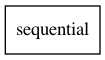

In [ ]:
plot_model(model, to_file='submission_2_web_traffic_timeseries.png')

### Plotting

#### Plot Model Loss

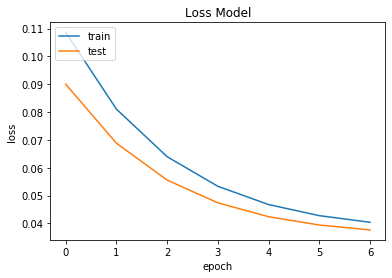

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot Model MAE

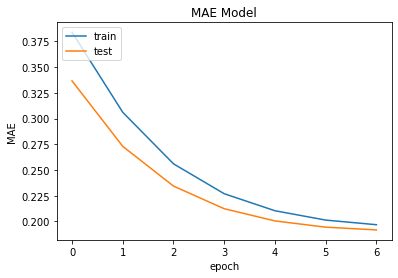

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()